In [1]:
import os
import glob
import pandas as pd

infiles = glob.glob('/home/pm/Documents_sync/PhD/StHelens/gnss_data/*.pos')

positions = {}

for infile in infiles:
    # retrieve station name
    station = os.path.basename(infile).split('.')[0]
    # retrieve GPS position and time dependent height
    df = pd.read_csv(infile, skiprows=36, delim_whitespace=True, usecols=[0,2,12,13, 14, 17])
    # create new date column
    df['date'] = pd.to_datetime(df['*YYYYMMDD'], format='%Y%m%d')
    positions[station] = df

In [2]:
print(positions['P694']['Elong'])

0       237.818068
1       237.818068
2       237.818068
3       237.818068
4       237.818068
           ...    
4554    237.818069
4555    237.818069
4556    237.818069
4557    237.818069
4558    237.818069
Name: Elong, Length: 4559, dtype: float64


In [11]:
import numpy as np
# smooth dU values
for station in positions.keys():
    positions[station]['dU_smoothed'] = positions[station]['dU'].rolling(30).mean()
    # enter station coordinates
    positions[station]['lat'] = positions[station]['NLat'][0]
    positions[station]['lon'] = positions[station]['Elong'][0]

taxis = min([min(p.date) for p in positions.values()]), max([max(p.date) for p in positions.values()])

taxis = pd.date_range(taxis[0], taxis[1], freq='D')

(-0.1, 0.1)

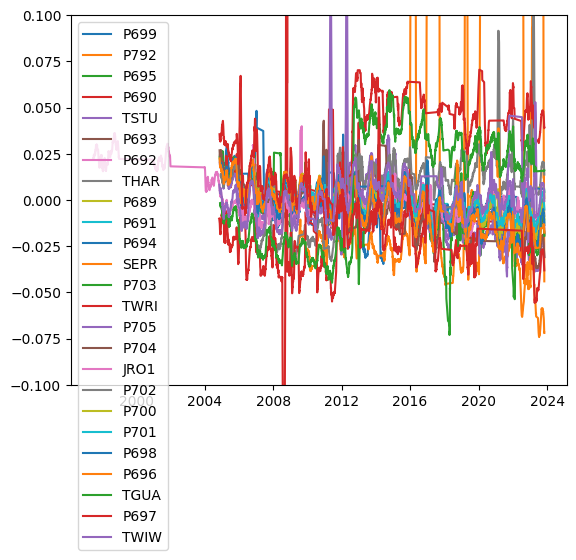

In [4]:
# plot this on a cartesian grid
import matplotlib.pyplot as plt
import numpy as np

# first simply in 1D
for station, df in positions.items():
    plt.plot(df['date'], df['dU_smoothed'], label=station)
plt.legend()
plt.ylim(-0.1, 0.1)

In [23]:
from obspy.geodetics import degrees2kilometers, locations2degrees
import numpy as np

# extents of the dv/v grid
lon = (-122.45, -122.02238458)
lat = (46.02, 46.36476256)
# Y-extent
y = degrees2kilometers(lat[1]- lat[0])

# X-Extent
x = degrees2kilometers(locations2degrees(lat[0], lon[0], lat[0], lon[1]))

res = 1  # km

# create grid
xaxis = np.arange(0, x, res)
yaxis = np.arange(0, y, res)

# create meshgrid
X, Y = np.meshgrid(xaxis, yaxis)

# create empty array
Z = np.zeros((len(yaxis), len(xaxis), len(taxis)))
# extent towards time axis


for station, df in positions.items():
    # compute cartesian coordinates of each station
    df['x'] = degrees2kilometers(locations2degrees(lat[0], lon[0], lat[0], df['lon'][0]))
    df['y'] = degrees2kilometers(locations2degrees(lat[0], lon[0], df['lat'][0], lon[0]))
    if np.min(np.abs(df['x'][0] - xaxis)) > res or np.min(np.abs(df['y'][0] - yaxis)) > res:
        print(f'Skipping {station}')
        continue
    

In [36]:
# # interpolate onto a spatial grid
# from scipy.interpolate import interp2d

# for kk, date in enumerate(taxis):
#     z_known = []
#     for station, df in positions.items():
#         try:
#             tii = np.where(date == df.date)[0][0]
#         except IndexError:
#             continue
#         z_known.append([df['x'][tii], df['y'][tii], df['dU_smoothed'][tii]])
#     if len(z_known) < 6:
#         continue
#     z_known = np.array(z_known)
#     # interpolate onto grid
#     interp = interp2d(z_known[:, 0], z_known[:, 1], z_known[:, 2], kind='cubic')
#     Z[:, :, kk] = interp(xaxis, yaxis).reshape(X.shape)


TypeError: m >= (kx+1)(ky+1) must hold

In [50]:
print(len(taxis))

9662


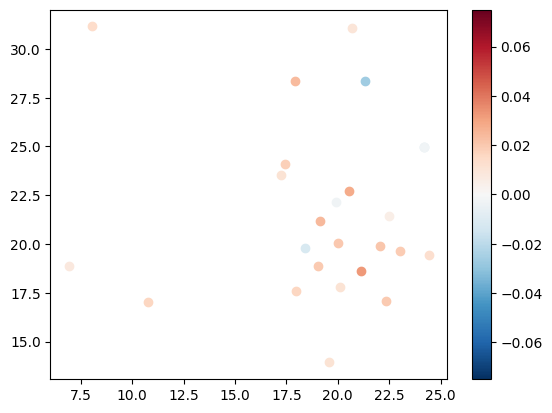

In [53]:
# create a scatter plot of the stations
# with the colour representing the height change
for station, df in positions.items():
    plt.scatter(df['x'].values[0], df['y'].values[0], c=df['dU_smoothed'].values[40], vmin=-0.075, vmax=0.075, cmap='RdBu_r')
plt.colorbar()